# Experiments

### Setup

In [1]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [2]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

Here is the RAG Application that we've been working with throughout this course

In [3]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio

# TODO: Configure this model!
MODEL_NAME = "gpt-4o"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    # If vector store exists, then load it
    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, index LangSmith documents and create new vector store
    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


USER_AGENT environment variable not set, consider setting it to identify your requests.


### Experiment

Here is a code snippet that should look similar to what you see from the starter code!

There are a few important components here.

1. We have defined an Evaluator
2. We pipe our dataset examples (dict) to the shape of input that our function `langsmith_rag` takes (str) using a target function

In [4]:
from langsmith import evaluate, Client

client = Client()
dataset_name = "RAG Application Golden Dataset"

def is_concise_enough(reference_outputs: dict, outputs: dict) -> dict:
    score = len(outputs["output"]) < 1.5 * len(reference_outputs["output"])
    return {"key": "is_concise", "score": int(score)}

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-4o"
)

C:\Users\Kush\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'gpt-4o-07089874' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/e99e2861-40bd-44b2-bf82-fe57e2c1c1e5/compare?selectedSessions=35c3fe50-66b0-4efc-a1a6-f25b0d7b6945




16it [00:42,  2.68s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,"Hello Kush this side, What does Life really me...",The meaning of life is a philosophical questio...,None,"I don't know the meaning of life, but to set u...",1,3.227398,bd9769e6-7436-46af-9596-5ae8940dc690,e2c8c820-b3e4-46bf-ac67-6f52bbdefc16
1,Can LangSmith help with creating training data...,"Yes, LangSmith can help create training datase...",None,"Yes, LangSmith can assist in creating training...",1,2.608599,e753429d-9583-4d30-a11c-901d138a0e05,78709cb1-c4f1-4c6c-b4bf-ae6e6152da7a
2,What is the purpose of the LangSmith CLI?,The retrieved context does not provide specifi...,None,The LangSmith CLI (Command Line Interface) ser...,1,2.496903,0b02417f-33c5-4f79-9cf6-a779100fe660,9435d6b8-a67a-4d58-abbe-657c631f4240
3,How does LangSmith aid in model evaluation?,LangSmith aids in model evaluation by providin...,None,LangSmith aids in model evaluation by offering...,1,3.828243,3b3032b4-9420-4f5d-902a-a449ccc1e310,883bc752-9548-4032-939f-09dae0459438
4,Is it possible to integrate LangSmith with oth...,The context does not explicitly mention integr...,None,"Yes, it is possible to integrate LangSmith wit...",1,2.325208,f7e1e7be-ea69-42ce-be3e-8236667a4a1c,694e6f8d-69f4-488a-ba08-4dcc57b6324d
5,What features does LangSmith providing for deb...,LangSmith provides features for debugging such...,None,LangSmith provides several features for debugg...,1,3.218202,bd270264-e4ce-4119-b748-d1a5a5adaec5,e88d2fc8-7d19-4188-8408-fe0a35fe3019
6,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,2.102211,05648517-2a32-400e-883a-437e0048ee26,253b7ff4-7d89-4515-af74-a1114c2dc13a
7,How can I trace with the @traceable decorator?,To trace with the @traceable decorator in Pyth...,None,To trace with the @traceable decorator in Pyth...,1,3.375136,0786ef48-ebe9-4e0e-8b54-b80aa062390e,f427d801-8a2b-400b-9ffa-7876415e1c48
8,Can LangSmith be used for finetuning and model...,"No, LangSmith is not designed for finetuning o...",None,"Yes, LangSmith can be used for fine-tuning and...",1,1.998481,0f2ac969-c546-4446-ad97-847edf7819da,e2fb5ec3-66b1-4aed-893a-07fb058224aa
9,What is LangSmith used for in three sentences?,LangSmith is used for running and managing exp...,None,LangSmith is a platform designed for the devel...,1,1.668566,2a66295d-ce3d-4178-a2e1-3f00ef023fec,4ac90335-5066-49d6-8128-8c7ab9f62e28


### Modifying your Application

Now, let's change our model to gpt-35-turbo and see how it performs!

Make this change, and then run this code snippet!

In [5]:
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-3.5-turbo"
)

View the evaluation results for experiment: 'gpt-3.5-turbo-11641579' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/e99e2861-40bd-44b2-bf82-fe57e2c1c1e5/compare?selectedSessions=65d7e19e-bf4a-47ed-8a06-b6fba8b77fb5




16it [00:36,  2.30s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,"Hello Kush this side, What does Life really me...",Life's meaning can vary widely based on indivi...,None,"I don't know the meaning of life, but to set u...",1,2.284711,bd9769e6-7436-46af-9596-5ae8940dc690,1821bdb6-6c17-4087-94c8-6f0992ecd522
1,Can LangSmith help with creating training data...,"Yes, LangSmith can help create training datase...",None,"Yes, LangSmith can assist in creating training...",1,1.771215,e753429d-9583-4d30-a11c-901d138a0e05,fbd10cb1-8595-477c-99bb-f931da082425
2,What is the purpose of the LangSmith CLI?,The purpose of the LangSmith CLI is to run Lan...,None,The LangSmith CLI (Command Line Interface) ser...,1,1.566280,0b02417f-33c5-4f79-9cf6-a779100fe660,92a925c2-db74-4941-9ccb-a8844f2d923b
3,How does LangSmith aid in model evaluation?,LangSmith aids in model evaluation by providin...,None,LangSmith aids in model evaluation by offering...,1,2.725659,3b3032b4-9420-4f5d-902a-a449ccc1e310,29f7d640-430d-4d89-908c-1ccfe19a6285
4,Is it possible to integrate LangSmith with oth...,The provided context does not specify whether ...,None,"Yes, it is possible to integrate LangSmith wit...",1,1.776829,f7e1e7be-ea69-42ce-be3e-8236667a4a1c,129eaddf-ecc6-4246-a240-c00d1f46740a
5,What features does LangSmith providing for deb...,LangSmith provides various debugging features ...,None,LangSmith provides several features for debugg...,1,3.389480,bd270264-e4ce-4119-b748-d1a5a5adaec5,041fddbe-e83c-411c-bc62-ff3cd5e2b849
6,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,1.779632,05648517-2a32-400e-883a-437e0048ee26,692f2006-aede-44b1-98b4-3367b3695845
7,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you si...",None,To trace with the @traceable decorator in Pyth...,1,2.097232,0786ef48-ebe9-4e0e-8b54-b80aa062390e,01ced480-664b-4f10-aa66-eb628c7d49b4
8,Can LangSmith be used for finetuning and model...,LangSmith is primarily a platform for LLM obse...,None,"Yes, LangSmith can be used for fine-tuning and...",1,2.332896,0f2ac969-c546-4446-ad97-847edf7819da,4c0e89be-c2ec-469b-a4f2-9142388a1564
9,What is LangSmith used for in three sentences?,LangSmith is used for running and managing exp...,None,LangSmith is a platform designed for the devel...,1,1.730822,2a66295d-ce3d-4178-a2e1-3f00ef023fec,86399c2c-99b0-44c3-8d71-1499848b0567


Added a screenshot showing that I have successfully run 2 experiments over my dataset using 2 different models namely gpt-4o and gpt-3.5-turbo

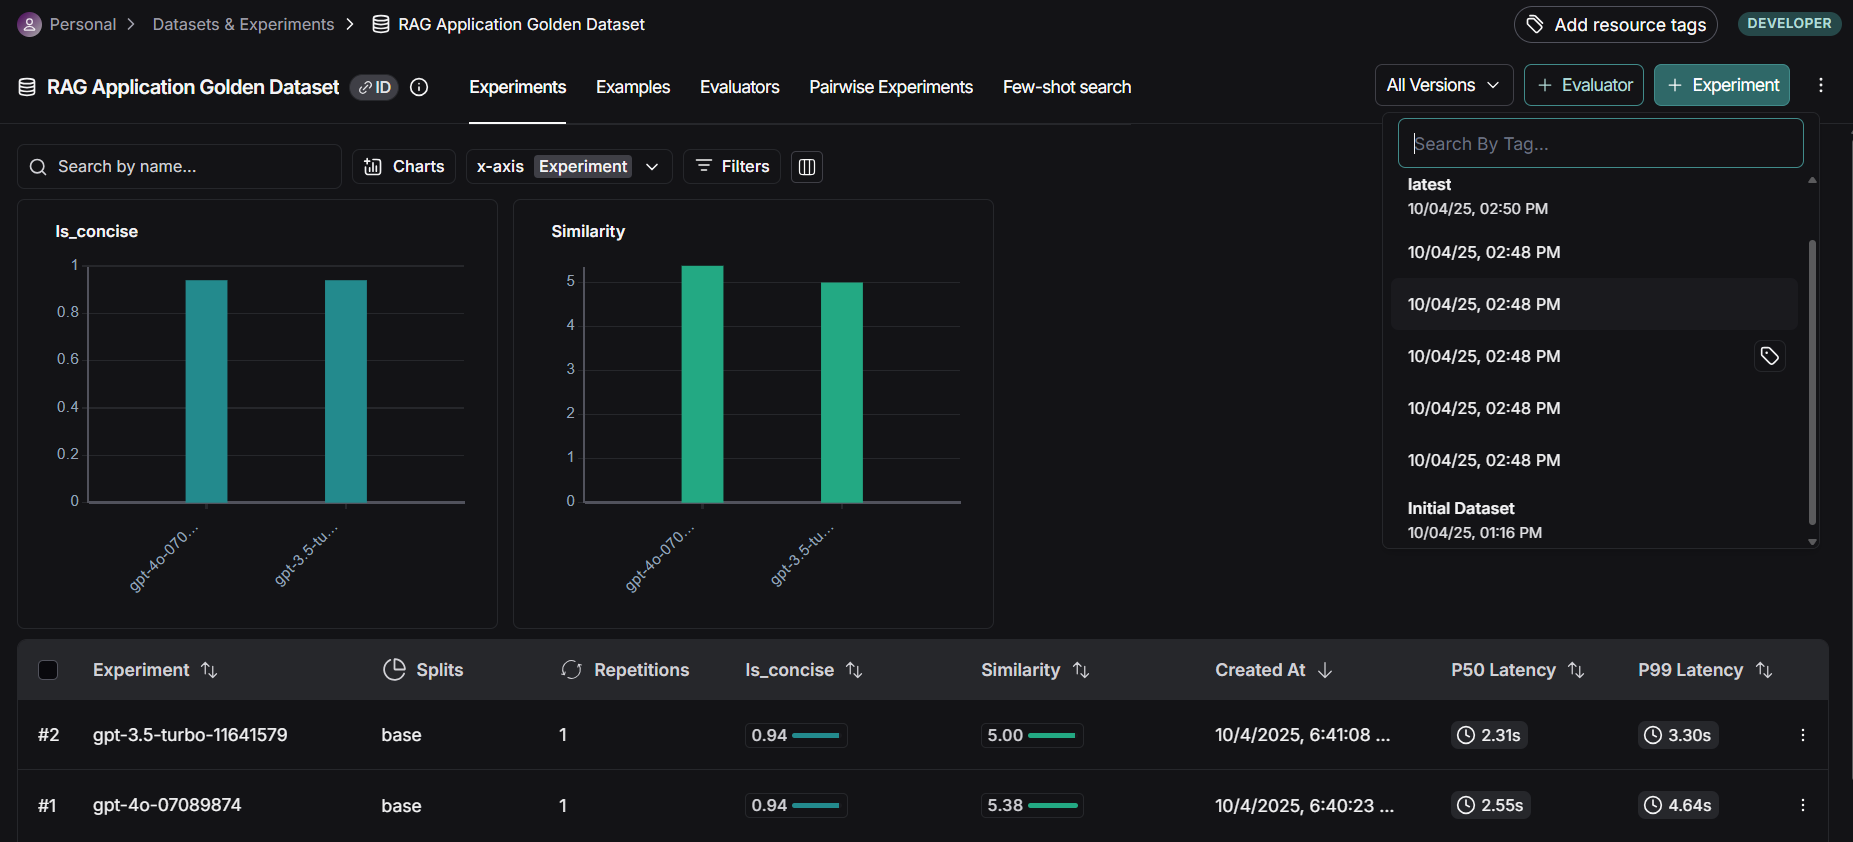

gpt-4o evaluation experiment
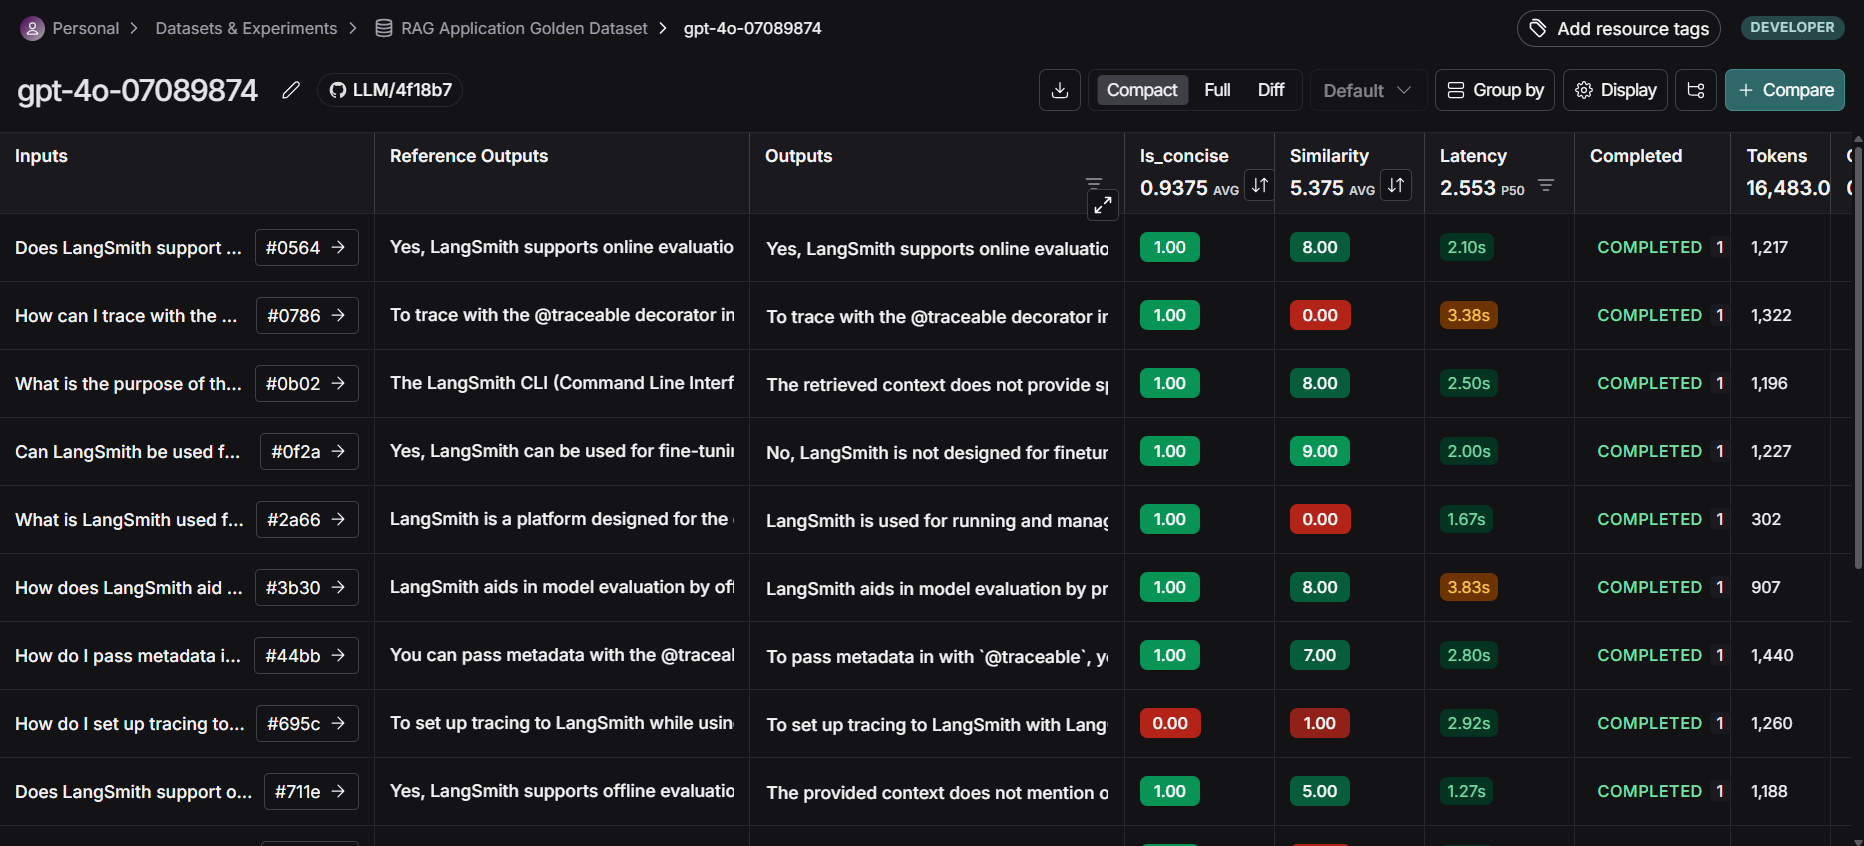

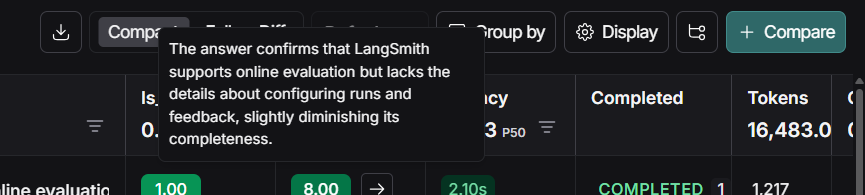

gpt-3.5-turbo Evaluation Experiment
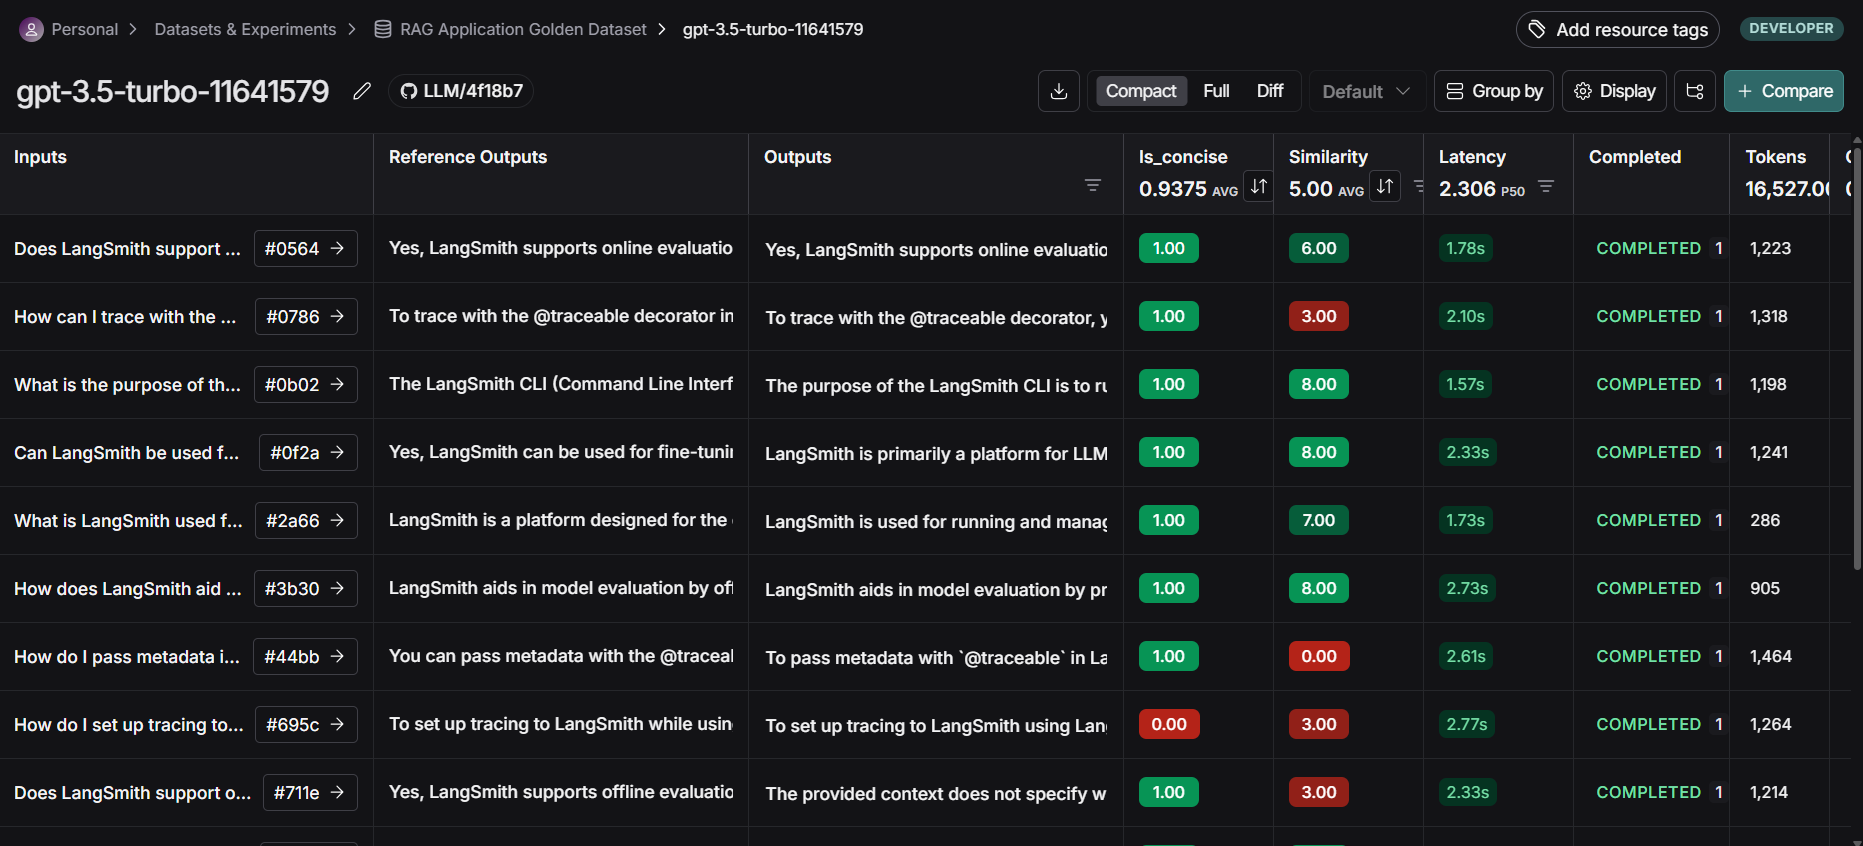

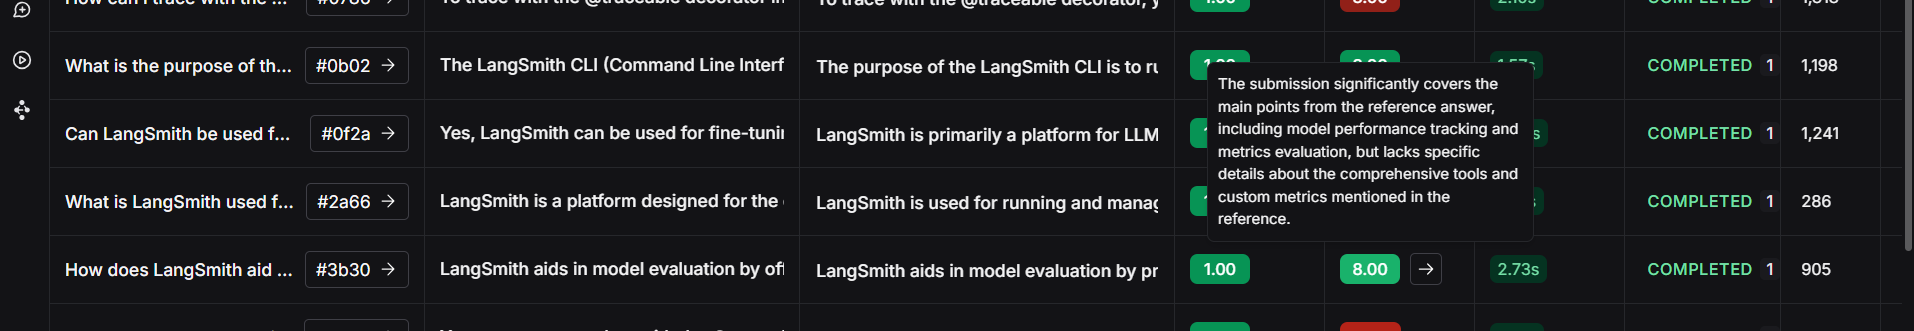

### Running over Different pieces of Data

##### Dataset Version

You can execute an experiment on a specific version of a dataset in the sdk by using the `as_of` parameter in `list_examples`

Let's try running on just our initial dataset.

In [7]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, as_of="Initial Dataset"),   # We use as_of to specify a version
    evaluators=[is_concise_enough],
    experiment_prefix="initial dataset version"
)

View the evaluation results for experiment: 'initial dataset version-8a50b40f' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/e99e2861-40bd-44b2-bf82-fe57e2c1c1e5/compare?selectedSessions=5e797caf-d8ed-410a-8605-836c7c6bd4d4




10it [00:24,  2.48s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,2.998258,05648517-2a32-400e-883a-437e0048ee26,8293694e-7b7a-41bd-b574-a5dfeb41864b
1,How can I trace with the @traceable decorator?,"To trace with the `@traceable` decorator, you ...",None,To trace with the @traceable decorator in Pyth...,1,2.990354,0786ef48-ebe9-4e0e-8b54-b80aa062390e,bccf9b04-945f-4a98-b4d7-f1293cf8b4f8
2,Can LangSmith be used for finetuning and model...,"LangSmith is designed for monitoring, evaluati...",None,"Yes, LangSmith can be used for fine-tuning and...",1,2.834691,0f2ac969-c546-4446-ad97-847edf7819da,20c1b308-85e0-4de5-a81a-42d75d5d87d0
3,What is LangSmith used for in three sentences?,LangSmith is used for running and managing exp...,None,LangSmith is a platform designed for the devel...,1,1.643867,2a66295d-ce3d-4178-a2e1-3f00ef023fec,ea197ac0-50d3-4efd-ac01-99ae5b54cd15
4,How do I pass metadata in with @traceable?,"To pass metadata with `@traceable`, add it int...",None,You can pass metadata with the @traceable deco...,1,2.358762,44bbb7de-a632-44db-8f83-b8c0228d36e6,cd4e963e-2c33-419f-b183-51ac51ace08c
5,How do I set up tracing to LangSmith if I'm us...,"To set up tracing to LangSmith with LangChain,...",None,To set up tracing to LangSmith while using Lan...,0,2.739099,695c2bea-983a-4488-b2ca-1b65a167aa93,1c8049b7-044a-4c68-ad4a-118db2bb24c4
6,Does LangSmith support offline evaluation?,"No, LangSmith focuses on online evaluations, p...",None,"Yes, LangSmith supports offline evaluation thr...",1,1.723198,711ecdec-003f-46fe-baa2-bf8bd8391ef2,702cb4d2-e768-49b0-a5f9-b593d51f1889
7,What testing capabilities does LangSmith have?,LangSmith allows you to run multiple experimen...,None,LangSmith offers capabilities for creating dat...,1,2.043921,7f95bfbd-94a3-44c4-b8d0-41003820b139,41591eda-acb9-4cac-ae69-eb21541e3b49
8,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.495253,85a184e2-553f-41e9-88b7-333f9e6f86a4,12f30e32-6d30-4125-ab5a-2309451ca047
9,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,2.357882,97afd1c9-0180-4fd4-b77f-7e8c3b870466,b59b90cf-cc19-42a7-9446-249537544ea4


##### Dataset Split

You can run an experiment on a specific split of your dataset, let's try running on the Crucial Examples split.

In [9]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, splits=["crucial examples"]),  # We pass in a list of Splits
    evaluators=[is_concise_enough],
    experiment_prefix="Crucial Examples split"
)

View the evaluation results for experiment: 'Crucial Examples split-4a68eead' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/e99e2861-40bd-44b2-bf82-fe57e2c1c1e5/compare?selectedSessions=92158824-6698-49dc-bacc-a386e30fcaae




5it [00:11,  2.30s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How can I trace with the @traceable decorator?,To trace with the @traceable decorator in Pyth...,None,To trace with the @traceable decorator in Pyth...,1,2.562416,0786ef48-ebe9-4e0e-8b54-b80aa062390e,78a680fa-cada-4f67-a3cf-379c3254aa23
1,What is LangSmith used for in three sentences?,LangSmith is used for running and managing exp...,None,LangSmith is a platform designed for the devel...,1,2.180631,2a66295d-ce3d-4178-a2e1-3f00ef023fec,de0ee835-83c5-44e4-9ed9-8f00f295125d
2,Does LangSmith support offline evaluation?,The retrieved context does not explicitly ment...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.535915,711ecdec-003f-46fe-baa2-bf8bd8391ef2,65db7b01-1d9c-4309-93ae-38ba27b72325
3,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.410975,85a184e2-553f-41e9-88b7-333f9e6f86a4,602d8098-c5f7-43ef-83d4-9c60e015af27
4,What features does LangSmith providing for deb...,LangSmith provides features such as tracing fo...,None,LangSmith provides several features for debugg...,1,2.308649,bd270264-e4ce-4119-b748-d1a5a5adaec5,7c359c48-05ac-466a-9d4c-69d9eff91fdc


##### Specific Data Points

You can specify individual data points to run an experiment over as well

In [12]:
evaluate(
    target_function,
    data=client.list_examples(
        dataset_name=dataset_name, 
        example_ids=[   # We pass in a specific list of example_ids
            # DONE: You will need to paste in your own example ids for this to work!
            "bd9769e6-7436-46af-9596-5ae8940dc690",
            "0b02417f-33c5-4f79-9cf6-a779100fe660"
        ]
    ),
    evaluators=[is_concise_enough],
    experiment_prefix="two specific example ids"
)

View the evaluation results for experiment: 'two specific example ids-aae3f2e7' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/e99e2861-40bd-44b2-bf82-fe57e2c1c1e5/compare?selectedSessions=8991c594-f599-41ba-8de5-cf211eac8820




2it [00:05,  2.64s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,What is the purpose of the LangSmith CLI?,The LangSmith CLI is used to interact with Lan...,None,The LangSmith CLI (Command Line Interface) ser...,1,2.396707,0b02417f-33c5-4f79-9cf6-a779100fe660,f5d0db51-05f3-424a-8eaa-878c7623c42e
1,"Hello Kush this side, What does Life really me...",The meaning of life is often explored through ...,None,"I don't know the meaning of life, but to set u...",1,2.390479,bd9769e6-7436-46af-9596-5ae8940dc690,1ec4b1c9-b660-49b0-bb9f-652f09876c8c


### Other Parameters

##### Repetitions

You can run an experiment several times to make sure you have consistent results

In [13]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="two repetitions",
    num_repetitions=2   # This field defaults to 1
)

View the evaluation results for experiment: 'two repetitions-e90f6716' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/e99e2861-40bd-44b2-bf82-fe57e2c1c1e5/compare?selectedSessions=fdb390aa-be8a-4a62-9478-a855a3a987a8




32it [06:12, 11.64s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you ne...",None,To trace with the @traceable decorator in Pyth...,1,2.371510,0786ef48-ebe9-4e0e-8b54-b80aa062390e,7f4a69ed-58b9-4818-a4d4-39c1b172f59d
1,What is LangSmith used for in three sentences?,LangSmith is used for running and managing mul...,None,LangSmith is a platform designed for the devel...,1,2.839664,2a66295d-ce3d-4178-a2e1-3f00ef023fec,46553292-9a6d-4706-8bed-61c40ef7a2e8
2,Does LangSmith support offline evaluation?,The provided context does not mention offline ...,None,"Yes, LangSmith supports offline evaluation thr...",1,2.235446,711ecdec-003f-46fe-baa2-bf8bd8391ef2,1fc3dc5f-908f-46d5-acdd-943a17193e76
3,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,70.989665,85a184e2-553f-41e9-88b7-333f9e6f86a4,c6aab26e-685a-4a62-9f81-4ac8ba44dfa1
4,What features does LangSmith providing for deb...,"LangSmith provides several debugging features,...",None,LangSmith provides several features for debugg...,1,2.161430,bd270264-e4ce-4119-b748-d1a5a5adaec5,ced171dc-1370-47cd-84b5-b99ce61862a6
5,"Hello Kush this side, What does Life really me...",Life's meaning is often subjective and philoso...,None,"I don't know the meaning of life, but to set u...",1,1.988053,bd9769e6-7436-46af-9596-5ae8940dc690,ff80e8b0-0dc5-485c-be29-ef26d5930670
6,Can LangSmith help with creating training data...,"Yes, LangSmith can help with creating training...",None,"Yes, LangSmith can assist in creating training...",1,2.016381,e753429d-9583-4d30-a11c-901d138a0e05,71d57a30-8a18-4850-9fe3-b695f8e09349
7,What is the purpose of the LangSmith CLI?,The LangSmith CLI is used to set up and manage...,None,The LangSmith CLI (Command Line Interface) ser...,1,1.498911,0b02417f-33c5-4f79-9cf6-a779100fe660,8d3fa418-6f2a-4269-9a09-27ed642995c4
8,How does LangSmith aid in model evaluation?,LangSmith aids in model evaluation through var...,None,LangSmith aids in model evaluation by offering...,1,2.329535,3b3032b4-9420-4f5d-902a-a449ccc1e310,a7ebb964-0c3a-47a0-af8c-762eeec26402
9,Is it possible to integrate LangSmith with oth...,The provided context does not specify whether ...,None,"Yes, it is possible to integrate LangSmith wit...",1,1.552242,f7e1e7be-ea69-42ce-be3e-8236667a4a1c,dff5b501-2b55-4770-b7f7-018aeb67ad6c


2 Repetitions Run on my is_concise_enough evaluator
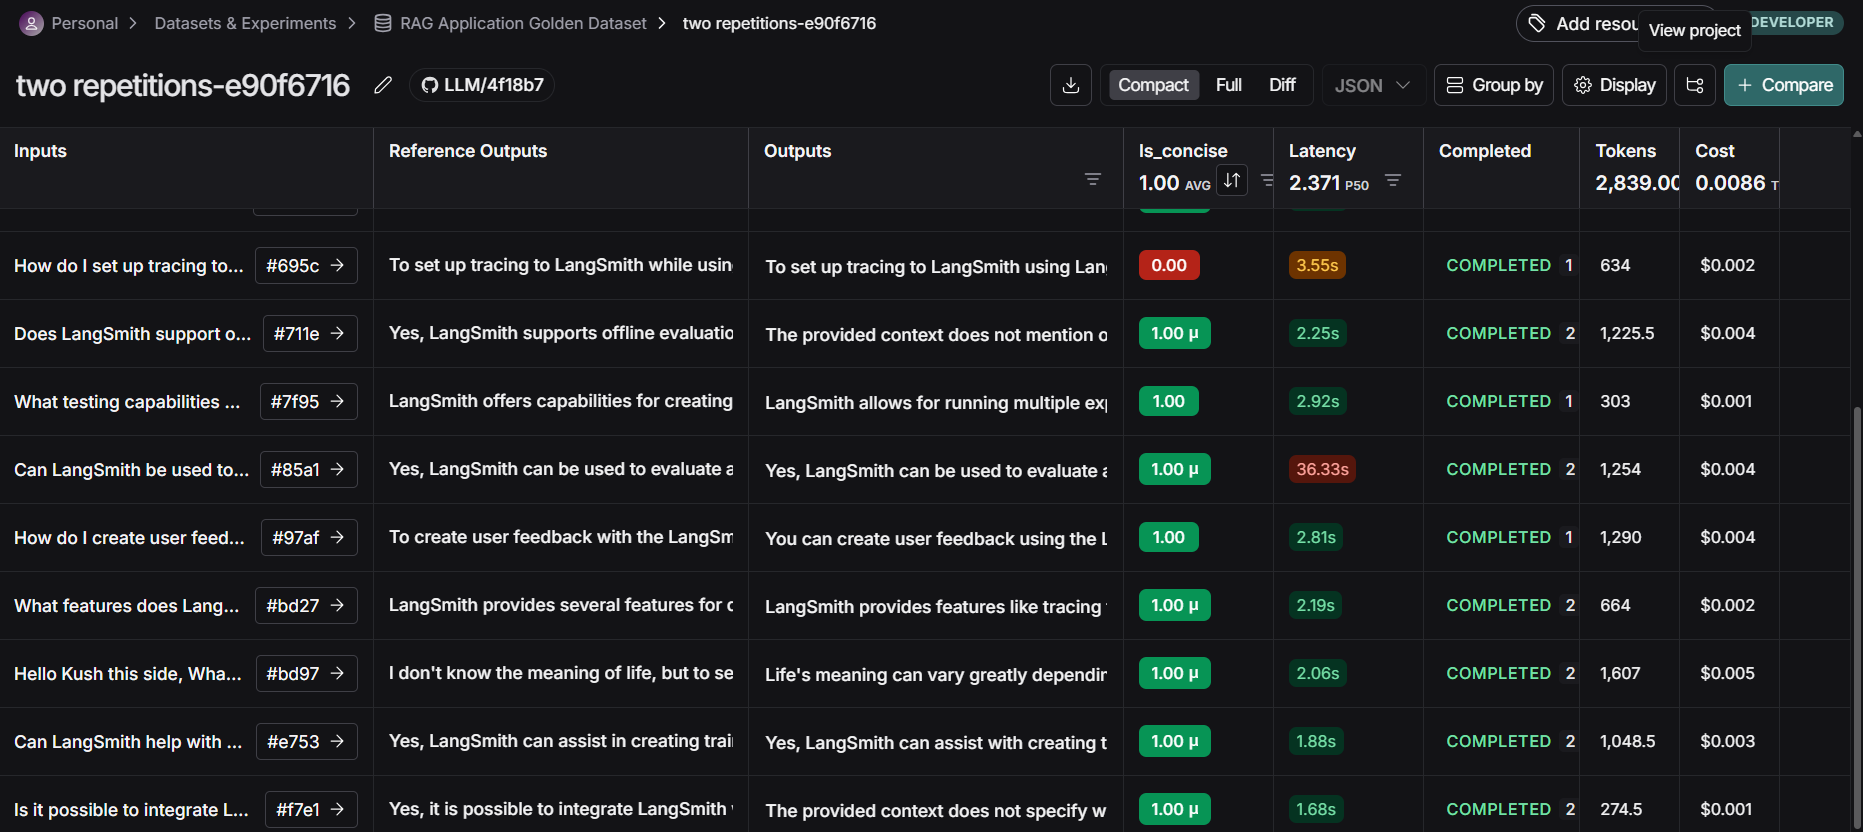

##### Concurrency
You can also kick off concurrent threads of execution to make your experiments finish faster!

In [14]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="concurrency",
    max_concurrency=3,  # This defaults to None, so this is an improvement!
)

View the evaluation results for experiment: 'concurrency-3ea531cd' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/e99e2861-40bd-44b2-bf82-fe57e2c1c1e5/compare?selectedSessions=de90c2ca-2f1e-4378-a1ab-8aa94874eeca




16it [00:13,  1.17it/s]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,What is LangSmith used for in three sentences?,LangSmith is used for running and managing exp...,None,LangSmith is a platform designed for the devel...,1,1.556581,2a66295d-ce3d-4178-a2e1-3f00ef023fec,6a37b5cd-4e85-4853-9c82-e5b56e292c3a
1,How can I trace with the @traceable decorator?,"To trace with the @traceable decorator, you fi...",None,To trace with the @traceable decorator in Pyth...,1,2.538644,0786ef48-ebe9-4e0e-8b54-b80aa062390e,a674479a-0d23-4d77-a591-b02a5d0287f0
2,Does LangSmith support offline evaluation?,The provided context does not mention LangSmit...,None,"Yes, LangSmith supports offline evaluation thr...",1,2.708014,711ecdec-003f-46fe-baa2-bf8bd8391ef2,a2b99ca3-c69f-4429-8b6f-3a5e4f1d5015
3,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.258075,85a184e2-553f-41e9-88b7-333f9e6f86a4,2f274980-1165-4172-96f9-fe62228d8bf2
4,What features does LangSmith providing for deb...,LangSmith provides several features for debugg...,None,LangSmith provides several features for debugg...,1,1.990810,bd270264-e4ce-4119-b748-d1a5a5adaec5,94ad3d8d-18a7-4a6e-b9d0-b91788e15c74
5,"Hello Kush this side, What does Life really me...",Life's meaning is subjective and varies for ev...,None,"I don't know the meaning of life, but to set u...",1,2.083004,bd9769e6-7436-46af-9596-5ae8940dc690,139376be-919a-4ab7-9dfb-ccffbdefb720
6,What is the purpose of the LangSmith CLI?,The context does not specifically mention the ...,None,The LangSmith CLI (Command Line Interface) ser...,1,1.408360,0b02417f-33c5-4f79-9cf6-a779100fe660,50b1461d-edb4-4e48-a754-f5bd72b72b09
7,Can LangSmith help with creating training data...,"Yes, LangSmith can help with creating training...",None,"Yes, LangSmith can assist in creating training...",1,2.371965,e753429d-9583-4d30-a11c-901d138a0e05,65c77435-72c8-4ffe-b876-fcefe661876e
8,How does LangSmith aid in model evaluation?,LangSmith aids in model evaluation by providin...,None,LangSmith aids in model evaluation by offering...,1,2.520095,3b3032b4-9420-4f5d-902a-a449ccc1e310,b36468eb-9fd8-41d4-b872-d8274678ea2f
9,Is it possible to integrate LangSmith with oth...,The provided context does not specify whether ...,None,"Yes, it is possible to integrate LangSmith wit...",1,1.983406,f7e1e7be-ea69-42ce-be3e-8236667a4a1c,419cf281-9b4e-46a6-a3a8-1831a168da52


##### Metadata 

You can (and should) add metadata to your experiments, to make them easier to find in the UI

In [15]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="metadata added",
    metadata={  # We can pass custom metadata for the experiment, such as the model name
        "model_name": MODEL_NAME
    }
)

View the evaluation results for experiment: 'metadata added-d1441ae8' at:
https://smith.langchain.com/o/8a49fc4d-4181-4f17-9fd6-756f8d955734/datasets/e99e2861-40bd-44b2-bf82-fe57e2c1c1e5/compare?selectedSessions=ecc92744-7ae6-4783-9136-316b1c0d78de




16it [10:37, 39.82s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How can I trace with the @traceable decorator?,To trace with the @traceable decorator in Pyth...,None,To trace with the @traceable decorator in Pyth...,1,4.107752,0786ef48-ebe9-4e0e-8b54-b80aa062390e,f3185772-979f-424a-94d3-8ef559321c2f
1,What is LangSmith used for in three sentences?,LangSmith is used for running and managing exp...,None,LangSmith is a platform designed for the devel...,1,116.132703,2a66295d-ce3d-4178-a2e1-3f00ef023fec,fa764033-9af3-4052-9694-46bd51a3f519
2,Does LangSmith support offline evaluation?,"No, LangSmith supports online evaluations, whi...",None,"Yes, LangSmith supports offline evaluation thr...",1,1.650101,711ecdec-003f-46fe-baa2-bf8bd8391ef2,d84a6a03-876f-4e14-aefa-dd27299032be
3,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,4.609308,85a184e2-553f-41e9-88b7-333f9e6f86a4,dca40e74-6045-4a1d-a4dc-42b3b90721b4
4,What features does LangSmith providing for deb...,LangSmith provides several features for debugg...,None,LangSmith provides several features for debugg...,1,2.469416,bd270264-e4ce-4119-b748-d1a5a5adaec5,1f1a9fbf-c304-41ff-9d36-84fea75e381d
5,"Hello Kush this side, What does Life really me...","Hello Kush, the meaning of life is a deeply ph...",None,"I don't know the meaning of life, but to set u...",1,2.835953,bd9769e6-7436-46af-9596-5ae8940dc690,608d8c01-58dc-466f-8315-a77dc9ea09b7
6,Can LangSmith help with creating training data...,"Yes, LangSmith can help with creating training...",None,"Yes, LangSmith can assist in creating training...",1,101.836750,e753429d-9583-4d30-a11c-901d138a0e05,47b91e01-93bb-4756-8caf-5900da070875
7,What is the purpose of the LangSmith CLI?,The LangSmith CLI is used to manage and intera...,None,The LangSmith CLI (Command Line Interface) ser...,1,1.741637,0b02417f-33c5-4f79-9cf6-a779100fe660,9da737d3-549e-48d6-8b7a-ac238b30e2e2
8,How does LangSmith aid in model evaluation?,LangSmith aids in model evaluation by offering...,None,LangSmith aids in model evaluation by offering...,1,2.328014,3b3032b4-9420-4f5d-902a-a449ccc1e310,730199ff-5372-4261-9ab4-1c9809e767e0
9,Is it possible to integrate LangSmith with oth...,The provided context does not specify whether ...,None,"Yes, it is possible to integrate LangSmith wit...",1,100.149834,f7e1e7be-ea69-42ce-be3e-8236667a4a1c,884e1a9f-16d8-415f-a5ae-e8d9b08a9c6b


All Experiment metrics comparisons (similarity_score and is_concise over the 2 models gpt-4o and gpt-3.5-turbo) over the Initial dataset tagged version and latest version dataset

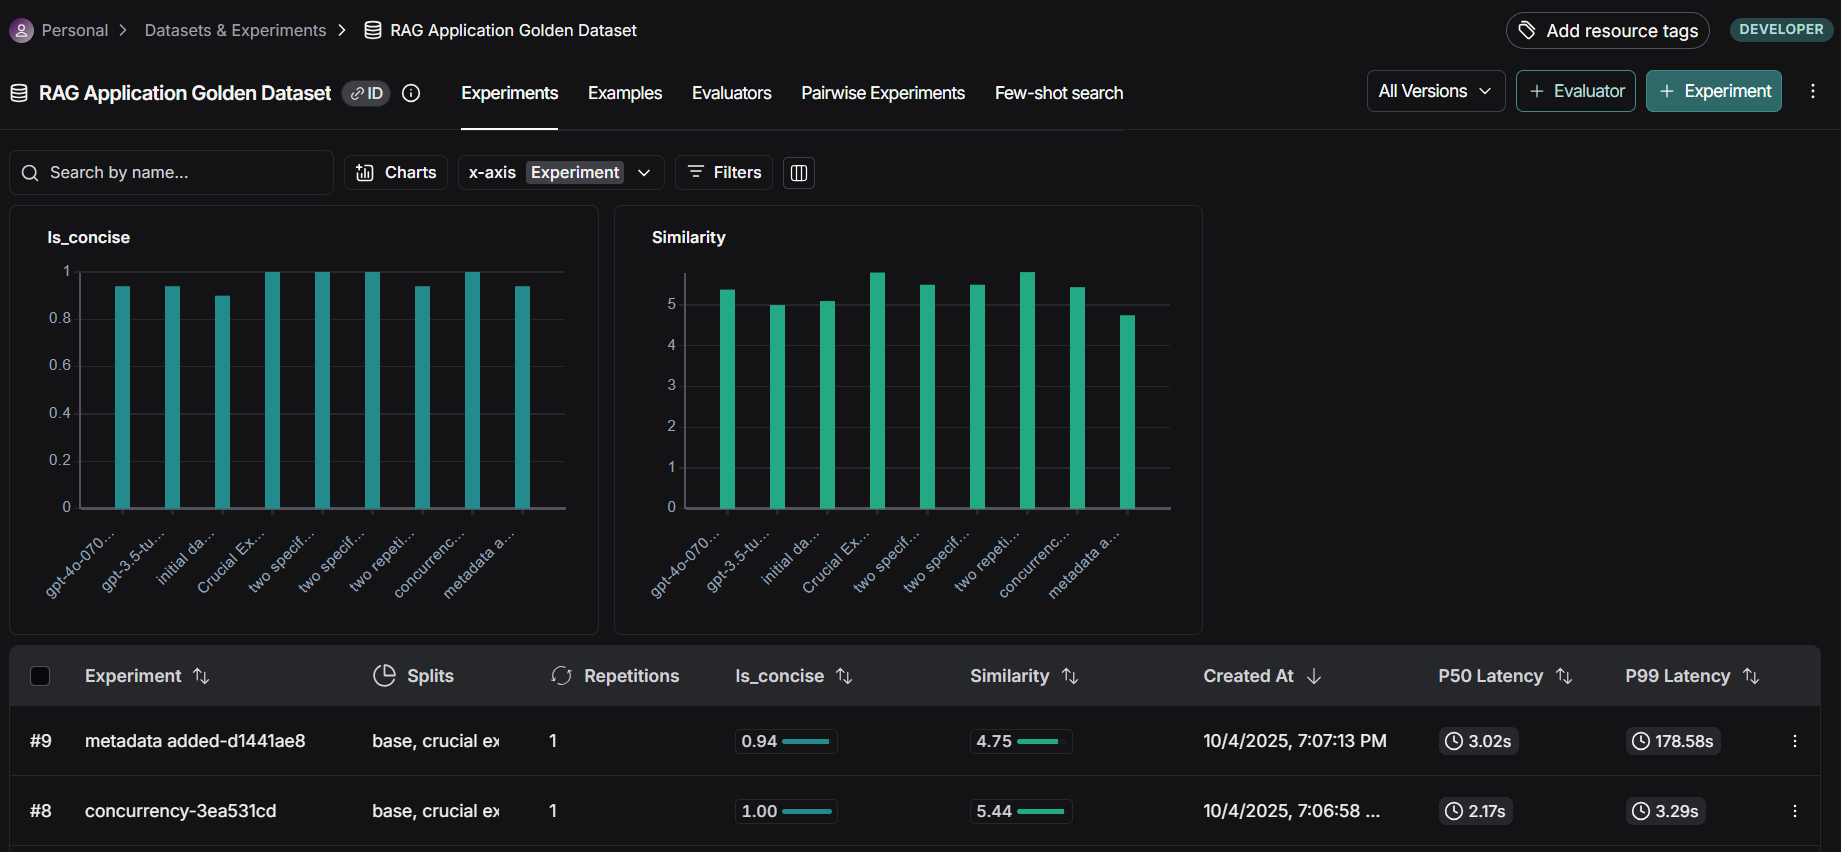

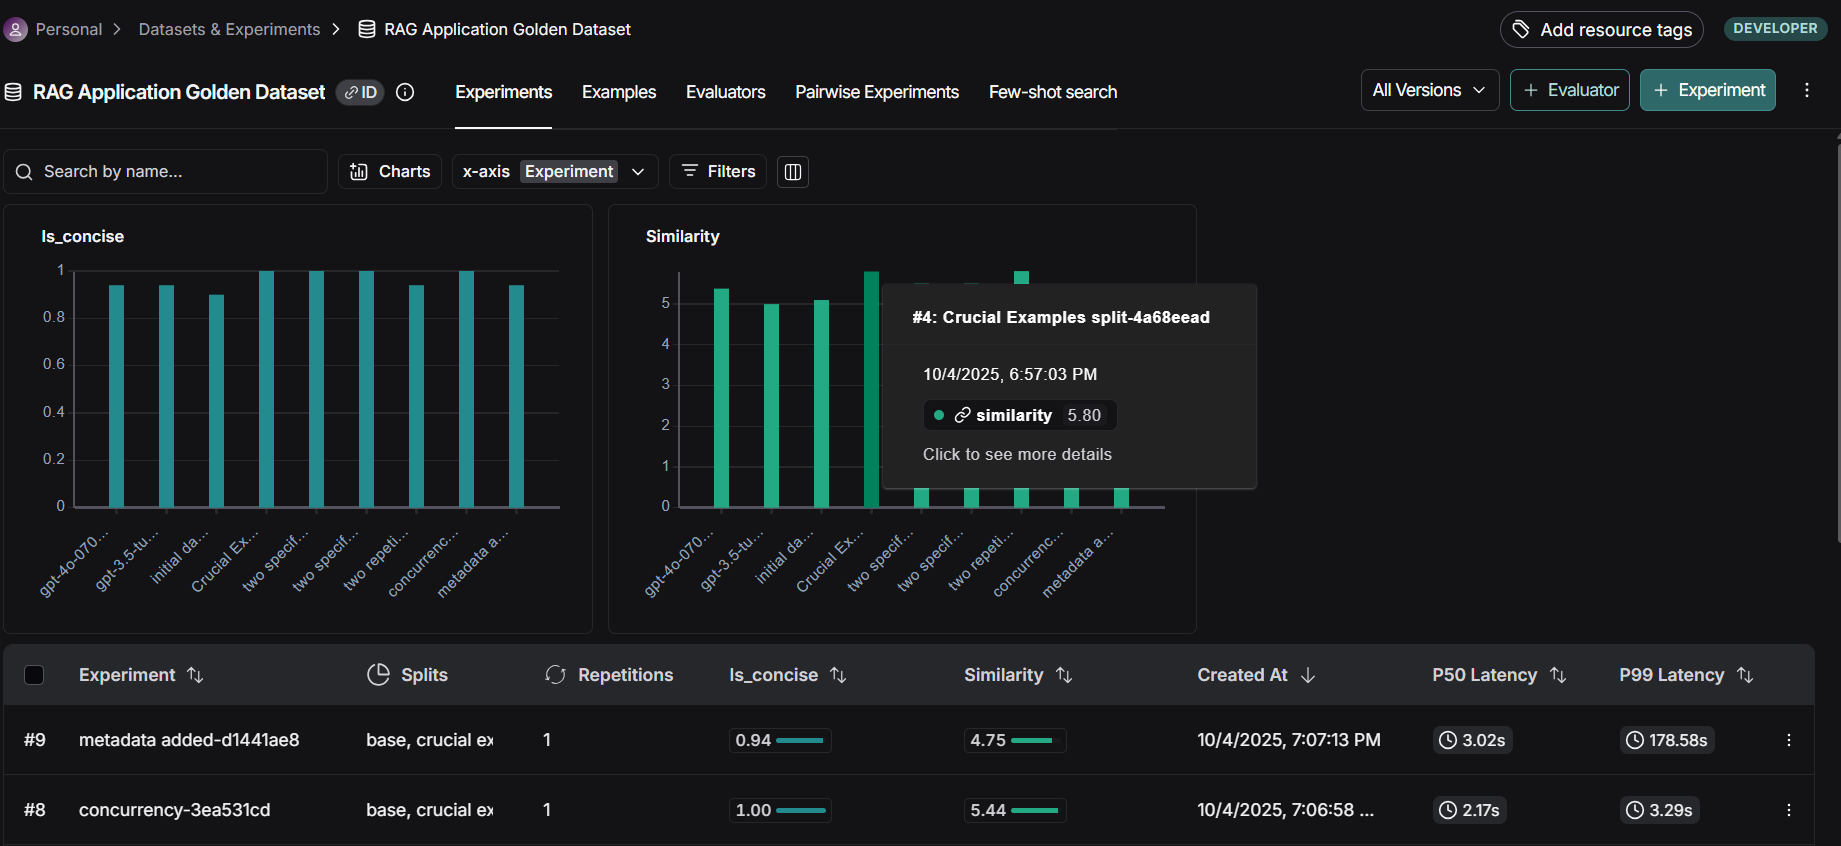
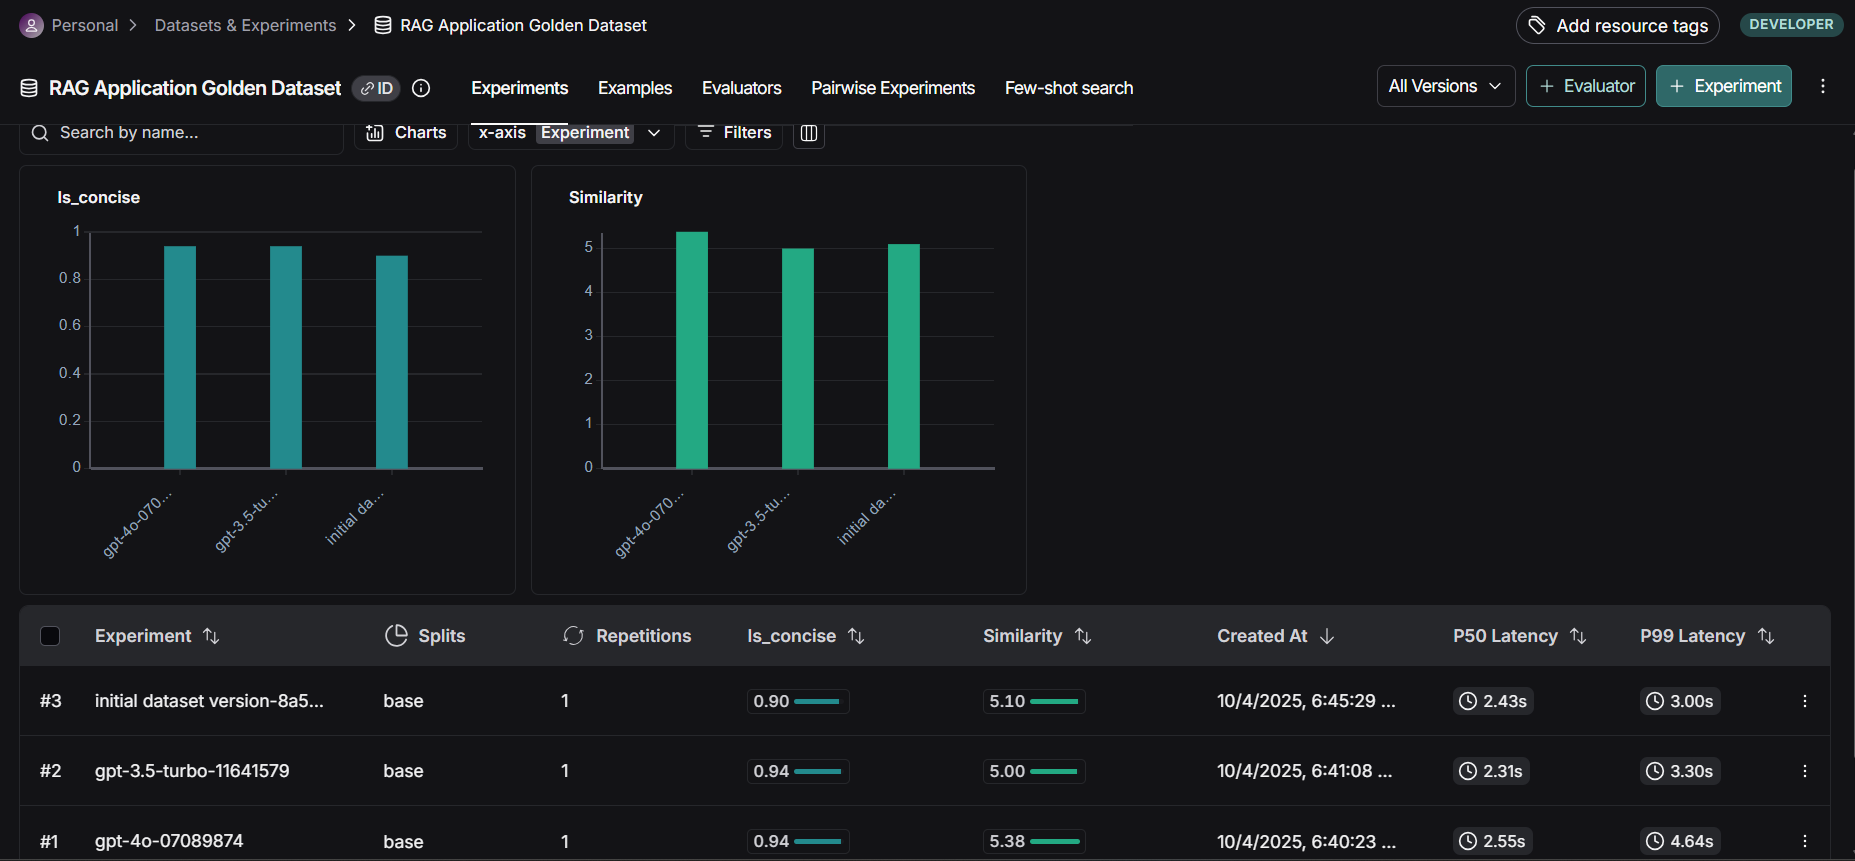